This script uses selenium to scrape the "Popular Times" data from Google searches. 

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import numpy as np
import csv
import requests

In [53]:
from pyvirtualdisplay import Display
from selenium import webdriver
import urllib
import time
from bs4 import BeautifulSoup
import re
from collections import defaultdict, OrderedDict, Counter
import random

# Scrape Address Data

Extract POI name, then extract POI address

In [66]:
POIs = []
query_template = 'https://places.cit.api.here.com/places/v1/discover/here?app_id=pqCZtpJDnv5d4q2yIPVv&app_code=gE4AFG_IP8Ym9Qgoi486VQ&at={},{}'

with open('combined_pois.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    counter = 0
    for row in reader:
        counter +=1
        dd = row
        dd['address'] = ''
        if not row['name']:
            continue
        query = query_template.format(row['lat'], row['lon'])
        response = requests.get(query)
        if response.status_code != 200:
            print("Error fetcting cell lat={}, lon={}".format(row['lat'], row['lon']))
            continue
        dd['address'] = response.json()['search']['context']['location']['address']['text'].replace('<br/>', ' ')
        if counter % 200 == 0:
            print('{} POIs have been processed'.format(counter))
        POIs.append(dd)

200 POIs have been processed
400 POIs have been processed
800 POIs have been processed
1000 POIs have been processed
1200 POIs have been processed
1400 POIs have been processed
1600 POIs have been processed
1800 POIs have been processed
2000 POIs have been processed


Save the POIs as CSV

In [128]:
outfile = 'combined_pois_address.csv'
with open(outfile, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=POIs[0].keys(), quoting=csv.QUOTE_NONNUMERIC)
    writer.writeheader()
    for poi in POIs:
        writer.writerow(poi)

# Test Run

Returns google search URL when given keyword. A few sample tests suggest that using the POI's name and address will return the Popular Times module. 

In [75]:
def get_url(keyword):
    template = 'https://www.google.com/search?client=ubuntu&channel=fs&q={}&ie=utf-8&oe=utf-8'
    url = template.format(urllib.parse.quote(keyword))
    return (url)

Get the content of the Popular times module if it exists.

1. Check if the sidebar module exists (check if class="xpdopen" exists)
1. Chekc if "Popular times" exists
1. Extract the histograms. Note that some bars have no height and some do not have a time label.

In [91]:
def get_popular_times(browser):
    """
    Params:
        browser: a browser instance generated by from selenium
    """
    histograms = defaultdict(list)
    
    ##Parse with BeautifulSoup
    html = browser.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    ##check if the sidebar exists
    if not soup.find_all('div', {'class': 'xpdopen'}):
        return None
    sidebar_soup = soup.find_all('div', {'class': 'xpdopen'})[0]
    
    ##check if "Popular times" exists
    if not sidebar_soup.find(text="Popular times"):
        return None
    
    ##We should have the histograms now
    histograms_soup = sidebar_soup.find_all('div', {'aria-label': re.compile('Histogram showing popular times on .')})
    
    for ss in histograms_soup:
        match = re.match('.+ ([A-Za-z]+)$', ss["aria-label"])
        ##Make sure that Mondays, Tuesdays, etc. are present
        assert(match)
        day = match.group(1)
        """
        Extract the bar heights and bar times blocks.
        They are probably preceeded by a SPAN element.
        """
        for tmp in ss.children:
            if tmp.name == 'span':
                siblings = tmp.fetchNextSiblings()
                bar_heights = siblings[0]
                bar_times = siblings[1]
        ##Now extract the bar height and bar time values
        bar_heights = list(bar_heights.children)
        bar_times = list(bar_times.children)
        ##make sure the number of bars matches the number of times
        assert(len(bar_heights) == len(bar_times))
        for bb_soup, tt_soup in zip(bar_heights, bar_times):
            bar_height = 0 
            """
            A typical line for bar heights:
                - no height:
                - w/ height: <div class="lubh-bar" style="height:3px"></div>
            """
            if bb_soup.has_attr('style'):
                mm = re.search('height: ([0-9]+)px', bb_soup['style'])
                if mm:
                    bar_height = int(mm.group(1))
            """
            A typical line for bar times:
                - no time: <div class="_tpj"></div>
                - w/ time: <div class="_ipj">3p</div> 
            """
            bar_time = ''
            mm = tt_soup.find('div', {'class': '_ipj'})
            if mm:
                bar_time = mm.text
            ##Save the extracted data
            histograms[day].append((bar_time, bar_height))
    return histograms
    

# Test Run

Here are some test search terms. If you search on Google using these terms, the Popular Times module will show up for some of the search terms. 

In [109]:
keywords = ["{} {}".format(ee['name'], ee['address']) for ee in random.sample(POIs, 4)]
keywords

['Consulate of Uruguay Auckland Central Auckland 1010 New Zealand',
 'The Golden Dawn - Tavern of Power Grey Lynn Auckland 1021 New Zealand',
 'Olli Onda Cafe Kingsland Auckland 1021 New Zealand',
 'Cafe Monet Remuera Auckland 1050 New Zealand']

Initiate the searches and scrape the popular times

In [110]:
##Start a browser instance
browser = webdriver.Chrome()
##Set window size
browser.set_window_size(1024, 1024)

popular_times = []
for kk in keywords:
    ##Open a web page. 
    browser.get(get_url(kk))
    ##It's best to wait a bit until the page loads
    time.sleep(4 + 2 * random.random())
    popular_times.append({
        "place": kk,
        "data": get_popular_times(browser)
    })
browser.close()

Recreate the popular times plot

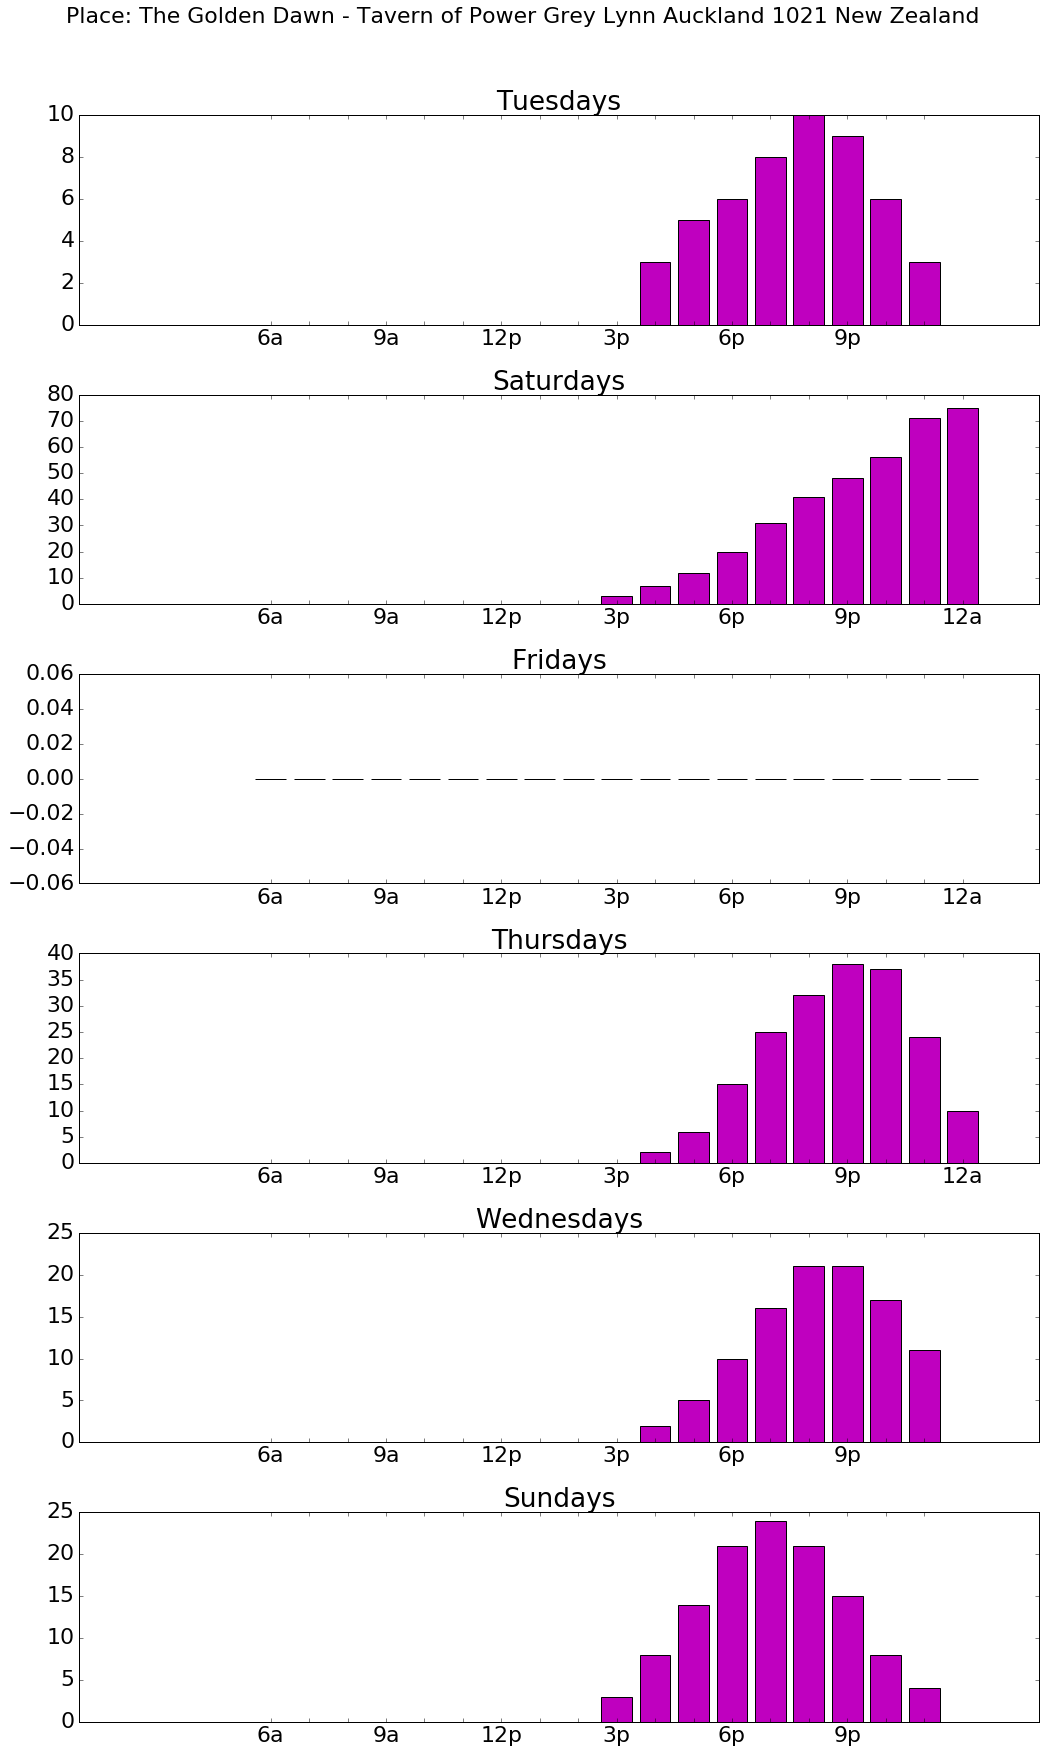

In [112]:
tt = popular_times[1]



tt_data = tt['data']
num_plots = len(tt_data)

fig, ax_arr = plt.subplots(num_plots, figsize=(15,25))


for ii, ee in enumerate(tt_data.items()):
    """ee is a tuple. 
    The first element is the day of week and
    the second element is the histogram
    """
    ax = ax_arr[ii]
    ax.set_title(ee[0])
    ticks, yy = list(zip(*ee[1]))
    ind = np.arange(len(yy))
    width = 0.8
    ax.bar(ind, yy, width, align='center', color='m', tick_label=ticks)


plt.tight_layout()
plt.suptitle("Place: {}".format(tt['place']))
plt.subplots_adjust(top=0.92)
plt.show()

# Find "Popular Times" for all the POIs

In [132]:
keywords = ["{} {}".format(ee['name'], ee['address']) for ee in POIs]
popular_times = []

##Start a browser instance
browser = webdriver.Chrome()
##Set window size
browser.set_window_size(1024, 1024)


counter = 0
for kk in keywords:
    counter += 1
    ##Open a web page. 
    browser.get(get_url(kk))
    ##It's best to wait a bit until the page loads
    time.sleep(2 + 2 * random.random())
    popular_times.append({
        "place": kk,
        "data": get_popular_times(browser),
        "html": browser.page_source
    })
    if counter % 200 == 0:
        print('{} POIs have been processed'.format(counter))
browser.close()

200 POIs have been processed
400 POIs have been processed
600 POIs have been processed
800 POIs have been processed
1000 POIs have been processed
1200 POIs have been processed
1400 POIs have been processed


TimeoutException: Message: timeout: cannot determine loading status
from timeout: Timed out receiving message from renderer: -0.002
  (Session info: chrome=51.0.2704.84)
  (Driver info: chromedriver=2.22.397932 (282ed7cf89cf0053b6542e0d0f039d4123bbb6ad),platform=Linux 3.13.0-88-generic x86_64)


**STOP HERE**

The previous run timed out, so let's run from where it broke

In [147]:
pass

In [146]:
start_num = 1400
popular_times = popular_times[0:start_num]
##Start a browser instance
browser = webdriver.Chrome()
##Set window size
browser.set_window_size(1024, 1024)
counter = 0

for kk in keywords[start_num:]:
    counter += 1
    ##Open a web page. 
    browser.get(get_url(kk))
    ##It's best to wait a bit until the page loads
    time.sleep(2 + 2 * random.random())
    popular_times.append({
        "place": kk,
        "data": get_popular_times(browser),
        "html": browser.page_source
    })
    if counter % 200 == 0:
        print('{} POIs have been processed'.format(counter))
browser.close()

In [152]:
with open("popular_times_full.json", 'w') as outfile:
    json.dump(popular_times, outfile)

In [155]:
with open("popular_times_simple.json", 'w') as outfile:
    json.dump([{'place': ee['place'], 'data': ee['data']} for ee in popular_times], outfile, indent=2)